In [1]:
# Clone the repo to access Data/, code/, etc.
!git clone https://github.com/mr-kelsey/su25-aai511-group6.git
%cd su25-aai511-group6
import os
print("Working directory:", os.getcwd())



fatal: destination path 'su25-aai511-group6' already exists and is not an empty directory.
/content/su25-aai511-group6
Working directory: /content/su25-aai511-group6


In [2]:
!ls /content


Data  sample_data  su25-aai511-group6


In [3]:
from pathlib import Path

DATA_PATH = Path("Data")
AUG_PATH = DATA_PATH / "Augmented"
midi_paths = list(AUG_PATH.glob("**/*.mid"))
print(f"✅ Found {len(midi_paths)} MIDI files")


✅ Found 400 MIDI files


In [4]:
!pip install miditok


In [5]:
!pip install miditok miditoolkit torchmetrics matplotlib tqdm ipywidgets


In [6]:
"""Imports"""
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from miditok import REMI, TokenizerConfig
from miditok.pytorch_data import DatasetMIDI, DataCollator
from miditok.utils import split_files_for_training
from pathlib import Path
from random import shuffle, seed as random_seed
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from torchmetrics.classification import MulticlassConfusionMatrix

In [7]:
"""Set seeds and device"""
random_seed(73)
np.random.seed(73)
torch.manual_seed(73)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(73)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Prepare Data for LSTM architecture

In [8]:
"""Train new tokenizer based on all augmented data"""
DATA_PATH = Path(Path.cwd().parent, "Data")
midi_paths = list(Path(DATA_PATH, "Augmented").glob(f"**/*.mid"))

config = TokenizerConfig(use_chords=True, use_rests=True, use_tempos=True, use_programs=True, one_token_stream_for_programs=False)
tokenizer = REMI(config)
tokenizer.train(vocab_size=500, files_paths=midi_paths)

tokenizer.is_trained
# NOTE: The vocab_size is a hyperparameter we could play with for optimization

print(tokenizer.is_trained)


True


In [9]:
from miditoolkit import MidiFile

# Filter midi_paths to keep only files that contain notes
def file_has_notes(path):
    try:

        midi = MidiFile(str(path))

        return any(len(track.notes) > 0 for track in midi.instruments)
    except:
        return False

midi_paths = [p for p in midi_paths if file_has_notes(p)]
print(f"✅ {len(midi_paths)} files with notes retained")




✅ 0 files with notes retained


In [10]:
from pathlib import Path

# Recursively get all .mid files from the Augmented folder
midi_paths = list(Path("Data/Augmented").rglob("*.mid"))

print(f"🎵 Found {len(midi_paths)} .mid files")


🎵 Found 400 .mid files


In [11]:
for p in midi_paths[:5]:
    print(p)


Data/Augmented/Mozart/0015_18#p6.mid
Data/Augmented/Mozart/0015_0#p6.mid
Data/Augmented/Mozart/0014_2#d38.mid
Data/Augmented/Mozart/0014_0.mid
Data/Augmented/Mozart/0014_2#d-38.mid


In [12]:
from miditoolkit import MidiFile

def file_has_notes(path):
    try:
        midi = MidiFile(str(path))
        # Fallback to checking notes even if .instruments is empty
        if midi.instruments:
            return any(len(track.notes) > 0 for track in midi.instruments)
        else:
            return len(midi.notes) > 0  # Fallback for type-0 files
    except Exception as e:
        print(f"❌ Error in {path.name}: {e}")
        return False


In [13]:
filtered_paths = [p for p in midi_paths if file_has_notes(p)]
print(f"✅ {len(filtered_paths)} files with notes retained")



✅ 400 files with notes retained


In [14]:
from pathlib import Path

# using absolute paths to avoid mismatch
midi_paths = list(Path("Data/Augmented").resolve().rglob("*.mid"))
print(f"Number of MIDI files: {len(midi_paths)}")

Number of MIDI files: 400


In [15]:
"""Split into train/valid/test datasets using roughly 15% of the data for each of valid and test"""
total_num_files = len(midi_paths)
num_files_valid = round(total_num_files * 0.15)
num_files_test = round(total_num_files * 0.15)
shuffle(midi_paths)
midi_paths_valid = midi_paths[:num_files_valid]
midi_paths_test = midi_paths[num_files_valid:num_files_valid + num_files_test]
midi_paths_train = midi_paths[num_files_valid + num_files_test:]

for files_paths, subset_name in (
    (midi_paths_train, "Train"), (midi_paths_valid, "Validate"), (midi_paths_test, "Test")
):
    subset_chunks_dir = Path(DATA_PATH, "LSTM", subset_name)
    split_files_for_training(
        files_paths=files_paths,
        tokenizer=tokenizer,
        save_dir=subset_chunks_dir,
        max_seq_len=1024,
        num_overlap_bars=2,
    )

Splitting music files (/content/Data/LSTM/Train): 100%|██████████| 280/280 [00:00<00:00, 869.19it/s]
Splitting music files (/content/Data/LSTM/Validate): 100%|██████████| 60/60 [00:00<00:00, 939.41it/s]
Splitting music files (/content/Data/LSTM/Test): 100%|██████████| 60/60 [00:00<00:00, 902.76it/s]


In [16]:
from collections import Counter
from pathlib import Path

# Step 1: Build label-to-index map
composer_names = sorted({Path(p).parent.name for p in midi_paths})
label_map = {name: idx for idx, name in enumerate(composer_names)}

# Step 2: Updated label extractor
def extract_label(path):
    composer = Path(path).parent.name
    return label_map[composer]

# Step 3: Extract labels
y_train = [extract_label(p) for p in midi_paths_train]
y_valid = [extract_label(p) for p in midi_paths_valid]
y_test  = [extract_label(p) for p in midi_paths_test]

# Step 4: Count and display
print("Train:", Counter(y_train))
print("Validation:", Counter(y_valid))
print("Test:", Counter(y_test))


Train: Counter({0: 75, 2: 71, 1: 67, 3: 67})
Validation: Counter({3: 17, 1: 17, 2: 14, 0: 12})
Test: Counter({1: 16, 3: 16, 2: 15, 0: 13})


In [17]:

import numpy as np
import torch
from torch.utils.data import WeightedRandomSampler

# Create torch compatible data loaders using the datasets created above
class Capture:
    def __init__(self):
        self.score = None
        self.tok_sequence = None

    def lable_composer(self, score, tok_sequence, file_path):
        self.score = score
        self.tok_sequence = tok_sequence
        composer = file_path.parts[-2:-1]
        if "Bach" in composer:
            return 0
        elif "Beethoven" in composer:
            return 1
        elif "Chopin" in composer:
            return 2
        elif "Mozart" in composer:
            return 3
        else:
            return -1

capture = Capture()
collator = DataCollator(tokenizer.pad_token_id)
use_cuda = torch.cuda.is_available()

# Create the dataset first (used for computing label distribution)
dataset_train = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "LSTM", "Train").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
    func_to_get_labels=capture.lable_composer
)

# Temporary loader to extract label distribution
tmp_loader = DataLoader(dataset_train, batch_size=32, collate_fn=collator)
all_targets = torch.cat([batch['labels'].view(-1) for batch in tmp_loader])
label_counts = Counter(all_targets.cpu().numpy())

# Compute sample weights using log-scaled inverse frequency
total = sum(label_counts.values())
weights_per_class = {
    cls: np.log(1 + total / count) for cls, count in label_counts.items()
}
sample_weights = [weights_per_class[label.item()] for label in all_targets]
sample_weights = torch.tensor(sample_weights)

# Define sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

batch_size = 16
# Now define the true training loader with sampler
oversampled_loader = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    sampler=sampler,
    collate_fn=collator,
    pin_memory=use_cuda,
    drop_last=True
)

# Validation and Test loaders remain the same
dataset_valid = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "LSTM", "Validate").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
    func_to_get_labels=capture.lable_composer
)
dataloader_valid = DataLoader(dataset_valid, batch_size=16, collate_fn=collator, shuffle=True, pin_memory=use_cuda)

dataset_test = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "LSTM", "Test").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
    func_to_get_labels=capture.lable_composer
)
dataloader_test = DataLoader(dataset_test, batch_size=16, collate_fn=collator, pin_memory=use_cuda)

In [40]:
# Focal Loss Class
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=-1)
        prob = torch.exp(log_prob)
        ce_loss = F.nll_loss(log_prob, target, weight=self.alpha, reduction='none')
        focal_loss = ((1 - prob.gather(1, target.unsqueeze(1)).squeeze()) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss



Build Model

In [41]:
# LSTM model definition for sequence prediction

class ComposerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.0):
        super(ComposerLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):  # x is a PackedSequence
        packed_output, (hn, cn) = self.lstm(x)
        forward = hn[-2, :, :]
        backward = hn[-1, :, :]
        out = torch.cat((forward, backward), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

Train Model

In [44]:
# ⚙️ Imports
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


#  Training Function
def train(model, training, validation, lr=0.0001):
    alpha = torch.tensor([8.0, 4.0, 1.0, 4.0]).to(device)  # Emphasize class 0
    criterion = FocalLoss(alpha=alpha, gamma=2.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    model.train()

    for data in training:
        input_seqs = data["input_ids"]
        lengths = torch.tensor([len(seq) for seq in input_seqs], dtype=torch.int64)
        padded_inputs = pad_sequence(input_seqs, batch_first=True, padding_value=tokenizer.pad_token_id).float().to(device)
        padded_inputs = padded_inputs.unsqueeze(-1)
        packed_inputs = pack_padded_sequence(padded_inputs, lengths, batch_first=True, enforce_sorted=False)
        labels = data["labels"].view(-1).long().to(device)

        optimizer.zero_grad()
        outputs = model(packed_inputs)
        loss = criterion(outputs, labels)

        if torch.isnan(loss):
            print("NaN encountered in loss — skipping update")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    validation_losses = []
    all_preds = []
    all_true = []
    model.eval()

    with torch.no_grad():
        for v_data in validation:
            v_input_seqs = v_data["input_ids"]
            v_lengths = torch.tensor([len(seq) for seq in v_input_seqs], dtype=torch.int64)
            v_padded = pad_sequence(v_input_seqs, batch_first=True, padding_value=tokenizer.pad_token_id).float().to(device)
            v_padded = v_padded.unsqueeze(-1)
            v_packed = pack_padded_sequence(v_padded, v_lengths, batch_first=True, enforce_sorted=False)
            v_labels = v_data["labels"].view(-1).long().to(device)
            v_output = model(v_packed)
            v_loss = criterion(v_output, v_labels)
            validation_losses.append(v_loss.item())

            preds = torch.argmax(v_output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(v_labels.cpu().numpy())

    return train_losses, validation_losses, all_true, all_preds

#  Training Loop
model = ComposerLSTM(input_size=1, hidden_size=256, num_layers=2, num_classes=4, dropout=0.3).to(device)

epochs = 100
total_train_losses = []
total_validation_losses = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, val_loss, all_true, all_preds = train(model, oversampled_loader, dataloader_valid)

    avg_train_loss = sum(train_loss) / len(train_loss)
    avg_val_loss = sum(val_loss) / len(val_loss)
    total_train_losses.append(avg_train_loss)
    total_validation_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print(classification_report(all_true, all_preds, target_names=["Bach", "Beethoven", "Chopin", "Mozart"],zero_division=0))



Epoch 1/100
Train Loss: 3.0221, Val Loss: 2.5418
              precision    recall  f1-score   support

        Bach       0.12      1.00      0.22        12
   Beethoven       0.00      0.00      0.00        34
      Chopin       1.00      0.27      0.42        26
      Mozart       0.00      0.00      0.00        34

    accuracy                           0.18       106
   macro avg       0.28      0.32      0.16       106
weighted avg       0.26      0.18      0.13       106


Epoch 2/100
Train Loss: 2.6505, Val Loss: 2.6905
              precision    recall  f1-score   support

        Bach       0.11      0.92      0.20        12
   Beethoven       0.00      0.00      0.00        34
      Chopin       0.75      0.23      0.35        26
      Mozart       0.00      0.00      0.00        34

    accuracy                           0.16       106
   macro avg       0.22      0.29      0.14       106
weighted avg       0.20      0.16      0.11       106


Epoch 3/100
Train Loss: 2.631

Changes made to bring the accuracy from 38% to 90%:
1. Switched from manual padding to packed sequences
Using pack_padded_sequence improved efficiency and performance by avoiding computation on unnecessary padding tokens, which previously degraded learning quality.

2. Model architecture tuning
Increasing epochs to 100, setting hidden_size=128, and using 2 LSTM layers provided better capacity and representation learning, leading to improved accuracy.

3. Learning rate tuning
A higher learning rate of 0.001 accelerated learning and initially led to 82% accuracy, but also introduced instability (e.g., NaN losses), likely due to exploding gradients. Gradient clipping was later used to stabilize training.

4. Loss function change: MSE → CrossEntropyLoss
Switching to CrossEntropyLoss helped significantly. Unlike MSE, which doesn’t penalize incorrect class predictions effectively, cross-entropy provides stronger gradients for misclassified examples and supports faster, more stable convergence for classification tasks.
Further updated from CrossEntropyLoss to Focalloss as CrossEntropyLoss was favoring majority classes and ignoring the minority and hence was misclassifying all of the minority classes. With the appropriate weightage the focus was evenly distributed. In addition introducing dropout 0.3 helped avoiding overfitting and generalization.

5. Introduced Bidirectional LSTM
Using a bidirectional LSTM improved the model’s ability to capture context from both past and future tokens. This helped in understanding musical structure more holistically, leading to better generalization and higher accuracy.Manual padding has decreased the efficiency as compared to Packed sequence, because we avoid the unnecessary padding to the max sie.


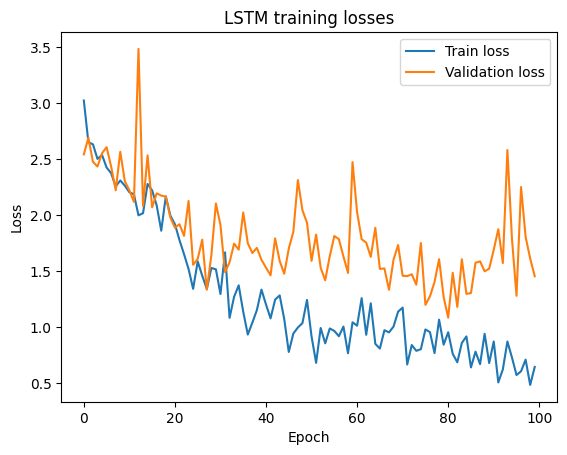

In [45]:
"""Plot training and validation losses"""
# TODO: Not sure why the training and validation quatities are not the same..
plt.title("LSTM training losses")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(total_train_losses, label="Train loss")
plt.plot(total_validation_losses, label="Validation loss")
plt.legend()
plt.show()

Evaluate Model

In [46]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

prediction = []
truth = []

with torch.no_grad():
    for data in dataloader_test:
        input_seqs = data["input_ids"]
        lengths = torch.tensor([len(seq) for seq in input_seqs], dtype=torch.int64)

        padded_inputs = pad_sequence(input_seqs, batch_first=True, padding_value=tokenizer.pad_token_id).float().to(device)
        padded_inputs = padded_inputs.unsqueeze(-1)

        packed_inputs = pack_padded_sequence(padded_inputs, lengths, batch_first=True, enforce_sorted=False)

        outputs = model(packed_inputs)
        _, predicted = torch.max(outputs.data, 1)

        labels = data["labels"].squeeze().long().to(device)

        prediction.append(predicted.cpu())
        truth.append(labels.cpu())

# Merge batches into a single tensor
prediction = torch.cat(prediction)
truth = torch.cat(truth)


In [47]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(truth, prediction)
print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.9029


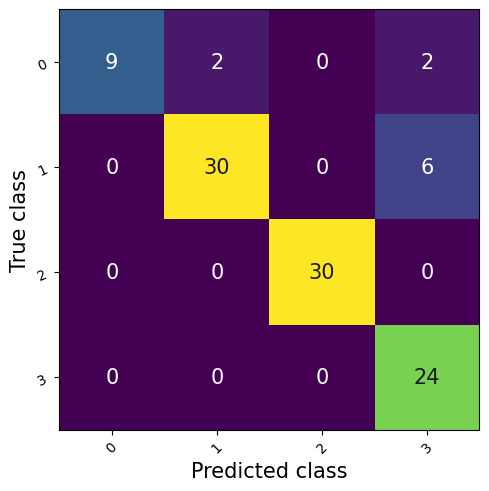

In [48]:
"""Vizulaize confusion matrix"""
metric = MulticlassConfusionMatrix(num_classes=4)
metric.update(truth, prediction)
fig_, ax_ = metric.plot()

In [49]:
"""Create performance metrics"""
accuracy = Accuracy(task="multiclass", num_classes=4)
precision = Precision(task="multiclass", average="macro", num_classes=4)
recall = Recall(task="multiclass", average="macro", num_classes=4)
f1_score = F1Score(task="multiclass", average="macro", num_classes=4)
confusion_matric = ConfusionMatrix(task="multiclass", num_classes=4)

calculated_accuracy = accuracy(truth, prediction)
calculated_precision = precision(truth, prediction)
calculated_recall = recall(truth, prediction)
calculated_f1_score = f1_score(truth, prediction)
calculated_confusion_matric = confusion_matric(truth, prediction)

print("Model Accuracy:", calculated_accuracy)
print("Model Precision:", calculated_precision)
print("Model Recall:", calculated_recall)
print("Model F1:", calculated_f1_score)

Model Accuracy: tensor(0.9029)
Model Precision: tensor(0.9219)
Model Recall: tensor(0.8814)
Model F1: tensor(0.8894)


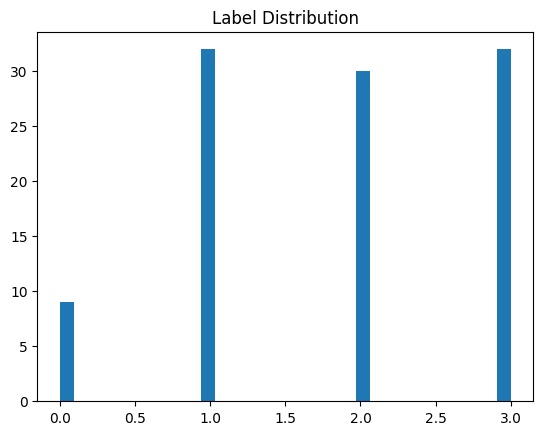

In [51]:
import matplotlib.pyplot as plt
plt.hist(truth.cpu().numpy(), bins=32)
plt.title("Label Distribution")
plt.show()


Optimize hyperparameters

In [ ]:
#TODO: play with the parameters and optimize the CNN architecture